In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy.io.wavfile import read
from python_speech_features import mfcc
from pydub import AudioSegment, silence
import warnings
warnings.filterwarnings('ignore')

E:\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
def visualizeFile(audioPath):
    audio_file_path = audioPath
    signal, sr = librosa.load(audio_file_path, sr=44100)

    # Visualize waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(signal, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # Compute spectrogram
    spectrogram = librosa.feature.melspectrogram(signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Visualize spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.show()

In [3]:
audio_dir = './processedData/'
n_components = 24
nfft=1200

In [4]:
speakers = {}
for speaker_dir in os.listdir(audio_dir):
    speaker_path = os.path.join(audio_dir, speaker_dir)
    if not os.path.isdir(speaker_path):
        continue
    print('Loading speaker:', speaker_dir)
    speaker_audio = []
    for audio_file in os.listdir(speaker_path):
        if not audio_file.endswith('.wav'):
            continue
        audio_path = os.path.join(speaker_path, audio_file)
        sampling_rate, audio = read(audio_path)
        features = mfcc(audio, sampling_rate,nfft=nfft)
        speaker_audio.append(features)
    # Train a GMM for the speaker
    speaker_audio = np.concatenate(speaker_audio, axis=0)
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(speaker_audio)
    speakers[speaker_dir] = gmm

Loading speaker: speaker1
Loading speaker: speaker2
Loading speaker: speaker3
Loading speaker: speaker4
Loading speaker: speaker5
Loading speaker: speaker6


In [5]:
#input_audio = read("./test/speaker1/Recording.wav")[1]
def predict(pt):
    input_audio = AudioSegment.from_file(pt)

    # Define the minimum length of silence to be considered as "silent"
    min_silence_len = 100 # in milliseconds
    # Define the silence threshold in dBFS (decibels relative to full scale)
    silence_thresh = -40 # in dBFS

    # Split the audio into parts separated by silence
    parts = silence.split_on_silence(input_audio, min_silence_len=min_silence_len, silence_thresh=silence_thresh)

    # Combine the parts back into a single audio file
    new_audio_pre = parts[0]
    for part in parts[1:]:
        new_audio_pre += part
    
    new_audio_pre.export("./test/temp.wav", format="wav")
    
    new_audio = read("./test/temp.wav")[1]
    new_features = mfcc(new_audio, sampling_rate)
    predictions = {}
    for speaker, gmm in speakers.items():
        prediction = gmm.score(new_features)
        predictions[speaker] = prediction
    max_value = max(predictions, key=lambda x: predictions[x])
    
    if predictions[max_value]>-100:
        return max_value
    else:
        return "Unknown Speaker"

In [6]:
df = pd.read_csv("./acc.csv")

In [7]:
predict("./test/speaker1/Recording.wav")

'speaker2'

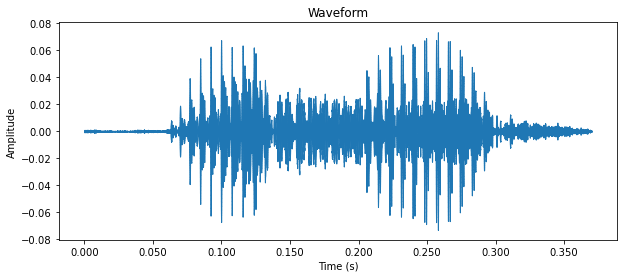

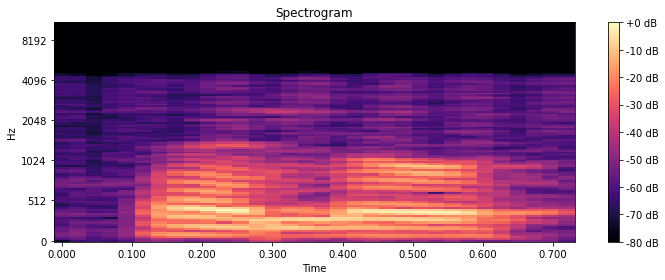

In [8]:
visualizeFile("./test/temp.wav")

In [9]:
li = []
for x in df['path']:
    #print(x, myfunc(x))
    li.append(predict(x))
    
df['predicted'] = li

df

,path,score,predicted
0,./test/speaker1/Recording.wav,speaker1,speaker2
1,./test/speaker2/Recording.wav,speaker2,speaker2
2,./test/speaker3/Recording.wav,speaker3,speaker3
3,./test/speaker4/Recording (1).wav,speaker4,speaker4
4,./test/speaker4/Recording (2).wav,speaker4,speaker4
5,./test/speaker4/Recording (3).wav,speaker4,speaker4
6,./test/speaker4/Recording (4).wav,speaker4,speaker4
7,./test/speaker4/Recording (5).wav,speaker4,speaker4
8,./test/speaker4/Recording (6).wav,speaker4,speaker4
9,./test/speaker4/Recording (7).wav,speaker4,speaker4


In [10]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(df['predicted'],df['score'])

0.9333333333333333

In [11]:
confusion_matrix(df['predicted'],df['score'])

array([[0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0],
       [0, 0, 0, 7, 0, 0],
       [0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 2]], dtype=int64)

In [12]:
print(classification_report(df['predicted'],df['score']))

              precision    recall  f1-score   support

    speaker1       0.00      0.00      0.00         0
    speaker2       1.00      0.50      0.67         2
    speaker3       1.00      1.00      1.00         2
    speaker4       1.00      1.00      1.00         7
    speaker5       1.00      1.00      1.00         2
    speaker6       1.00      1.00      1.00         2

    accuracy                           0.93        15
   macro avg       0.83      0.75      0.78        15
weighted avg       1.00      0.93      0.96        15

